In [30]:
import pandas as pd
import numpy as np
import os
import shap
from scipy.stats import ttest_ind

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 경로 설정 (Windows용)
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()
mpl.rc("font", family=font_name)

# 마이너스 깨짐 방지
mpl.rcParams["axes.unicode_minus"] = False

os.getcwd()

ROOT = "c:\\Users\\1004c\\Desktop\\통계청 논문 공모전"

In [ ]:
# Load uploaded files
df_result = pd.read_csv(os.path.join(ROOT, "Data", "T3_Y1", "T3_mean_Boosting_reg.csv"))
df_covariates = pd.read_csv(os.path.join(ROOT, "Data", "T3_Y1", "df_cf_T3.csv"))

# Merge by index (assuming row alignment)
df_merged = df_result.copy()
df_merged["Y"] = df_covariates["Y_임금근로자_첫_일자리"].reset_index(drop=True)

# Add treatment indicator (0/1)
df_merged["T"] = df_covariates["T3_취업성공패키지_참여경험"].reset_index(drop=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X1_성별                  9091 non-null   int64  
 1   X1_연령대                 9091 non-null   object 
 2   X1_졸업평점점수              9091 non-null   float64
 3   X1_졸업평점결측              9091 non-null   int64  
 4   X1_혼인여부                9091 non-null   int64  
 5   X1_부모학력                9091 non-null   float64
 6   X1_부모소득구간              9091 non-null   object 
 7   X2_설립유형_국공립            9091 non-null   int64  
 8   X2_소재지_지방              9091 non-null   int64  
 9   X2_전공그룹                9091 non-null   object 
 10  X2_학교유형_4년제이상          9091 non-null   int64  
 11  X3_진로교육_참여개수           9091 non-null   int64  
 12  X3_취업준비활동_참여개수         9091 non-null   int64  
 13  X3_대학_재학_중_일자리_경험의_유무  9091 non-null   int64  
 14  X3_어학연수_경험_횟수          9091 non-null   int64  
 15  X3_자

In [9]:
df_merged["T"].value_counts()

T
Control    4129
Treated     379
Name: count, dtype: int64

In [10]:
# tau와 interval length 계산
df_merged["tau"] = (df_merged["lower"] + df_merged["upper"]) / 2
df_merged["interval_length"] = df_merged["upper"] - df_merged["lower"]

# Update confidence score using the approximate tau
median_tau = df_merged["tau"].median()
lambda_val = 1.0
df_merged["conf_score"] = (df_merged["lower"] > 0).astype(int) + lambda_val * (df_merged["tau"] / df_merged["interval_length"])

# Top 25% based on updated score
top_25_cutoff = df_merged["conf_score"].quantile(0.75)
df_top25 = df_merged[df_merged["conf_score"] >= top_25_cutoff]

# Extract covariates for top25
df_top25_covs = df_covariates.loc[df_top25.index].reset_index(drop=True)
df_top25_covs["group"] = "top25"

# Bottom 75%
df_bottom75_covs = df_covariates.loc[~df_covariates.index.isin(df_top25.index)].reset_index(drop=True)
df_bottom75_covs["group"] = "bottom75"

# Combine
df_compare_tau_based = pd.concat([df_top25_covs, df_bottom75_covs], ignore_index=True)

In [11]:
df_compare_tau_based.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4508 entries, 0 to 4507
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X1_성별                  4508 non-null   int64  
 1   X1_연령대                 4508 non-null   object 
 2   X1_졸업평점점수              4508 non-null   float64
 3   X1_졸업평점결측              4508 non-null   int64  
 4   X1_혼인여부                4508 non-null   int64  
 5   X1_부모학력                4508 non-null   float64
 6   X1_부모소득구간              4508 non-null   object 
 7   X2_설립유형_국공립            4508 non-null   int64  
 8   X2_소재지_지방              4508 non-null   int64  
 9   X2_전공그룹                4508 non-null   object 
 10  X2_학교유형_4년제이상          4508 non-null   int64  
 11  X3_진로교육_참여개수           4508 non-null   int64  
 12  X3_취업준비활동_참여개수         4508 non-null   int64  
 13  X3_대학_재학_중_일자리_경험의_유무  4508 non-null   int64  
 14  X3_어학연수_경험_횟수          4508 non-null   int64  
 15  X3_자

In [15]:
df_compare_tau_based.drop("X1_혼인여부", axis=1, inplace=True)

### 1. Logistic Regression

In [ ]:
# 1. 데이터 준비
df = df_compare_tau_based.copy()
df["group_bin"] = (df["group"] == "top25").astype(int)

# 제외할 열
exclude_cols = ["group", "group_bin", "Y_임금근로자_첫_일자리", "T3_취업성공패키지_참여경험"]

# 독립변수 X / 종속변수 y
X = df.drop(columns=exclude_cols)
y = df["group_bin"]

# 범주형 변수 인코딩 (get_dummies 사용)
X_encoded = pd.get_dummies(X, drop_first=False)

# 2. 로지스틱 회귀
logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(X_encoded, y)
logit_coef = pd.Series(logit_model.coef_[0], index=X_encoded.columns).sort_values(key=np.abs, ascending=False)

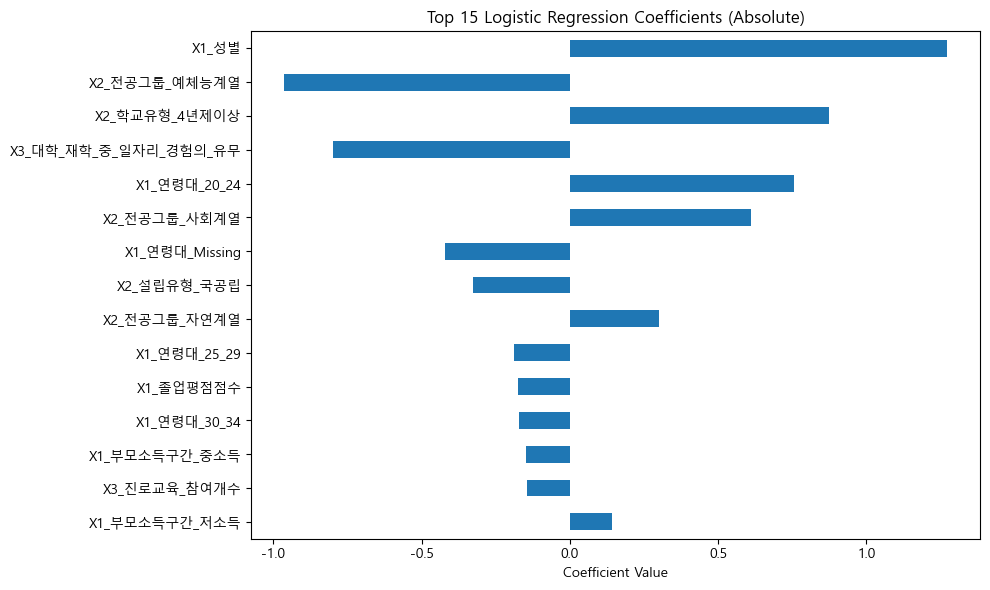

In [17]:
# 상위 15개 계수만 시각화
top_logit = logit_coef.head(15)

plt.figure(figsize=(10, 6))
top_logit.plot(kind='barh')
plt.gca().invert_yaxis()  # 위에서부터 큰 순서로 보이도록
plt.title("Top 15 Logistic Regression Coefficients (Absolute)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

In [18]:
odds_ratios = np.exp(logit_model.coef_[0])
pd.Series(odds_ratios, index=X_encoded.columns).sort_values(ascending=False)

X1_성별                    3.564878
X2_학교유형_4년제이상            2.394816
X1_연령대_20_24             2.127740
X2_전공그룹_사회계열             1.842038
X2_전공그룹_자연계열             1.350914
X1_부모소득구간_저소득            1.153346
X2_소재지_지방                1.045037
X2_전공그룹_공학계열             1.027140
X3_어학연수_경험_횟수            1.015867
X1_부모학력                  1.015185
X1_부모소득구간_Missing        1.013342
X3_자격증_소지_개수             1.004450
X1_부모소득구간_고소득            0.967772
X1_졸업평점결측                0.946793
X3_취업준비활동_참여개수           0.916480
X3_진로교육_참여개수             0.865299
X1_부모소득구간_중소득            0.862896
X1_연령대_30_34             0.842072
X1_졸업평점점수                0.838487
X1_연령대_25_29             0.829103
X2_설립유형_국공립              0.720756
X1_연령대_Missing           0.657007
X3_대학_재학_중_일자리_경험의_유무    0.449716
X2_전공그룹_예체능계열            0.381848
dtype: float64

### 2. Random Forest

In [19]:
# 3. 랜덤포레스트
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_encoded, y)
rf_importance = pd.Series(rf_model.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)

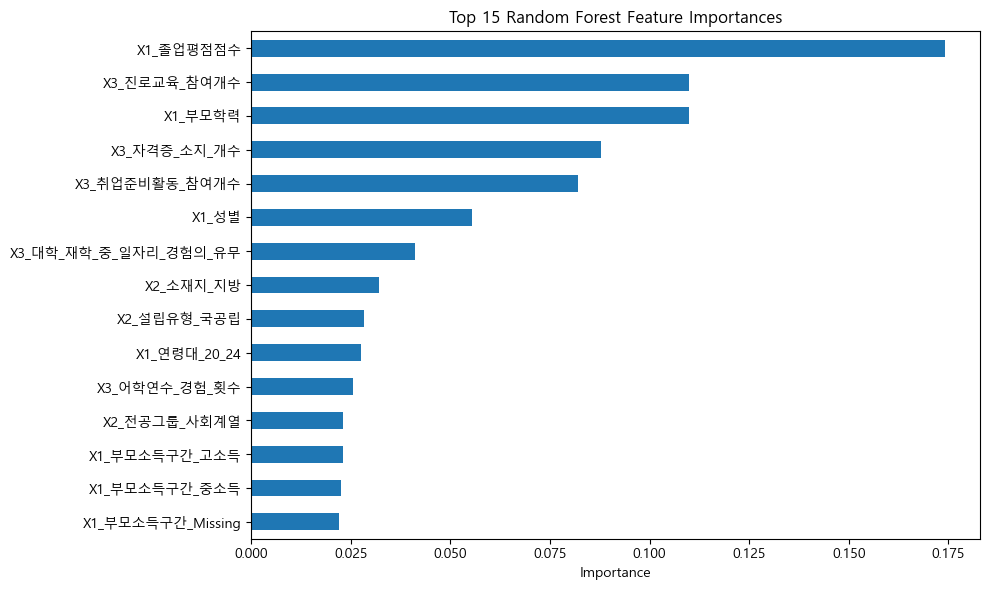

In [20]:
# 상위 15개 중요도 변수
top_rf = rf_importance.head(15)

plt.figure(figsize=(10, 6))
top_rf.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

- random forest, logistic regression 차이 확인
	- 공통 상위 10개 변수 확인
	- SHAP value 분석
	- interaction value 분석

In [21]:
# 1. 공통 상위 변수 리스트 (top 20 from each model, intersected)
top_logit = set(logit_coef.abs().sort_values(ascending=False).head(10).index)
top_rf = set(rf_importance.sort_values(ascending=False).head(10).index)
common_top_vars = list(top_logit & top_rf)

# Display
common_top_vars_df = pd.DataFrame(common_top_vars, columns=["Common_Top_Variables"])
common_top_vars_df

,Common_Top_Variables
0,X3_대학_재학_중_일자리_경험의_유무
1,X2_설립유형_국공립
2,X1_연령대_20_24
3,X1_성별


- Shap Value

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_encoded)  # shape: (9602, 22, 2)

# class 1에 해당하는 SHAP 값만 사용
shap_values_class_1 = shap_values[:, :, 1]  # (samples, features)

# 시각화
shap.summary_plot(shap_values_class_1, X_encoded, plot_type="bar", show=False)

In [ ]:
# SHAP value가 ndarray 형태라면
shap_df = pd.DataFrame(shap_values_class_1, columns=X_encoded.columns)

# 저장
file_path = os.path.join(ROOT, "Data", "T3_Y1", "shap_values.csv")
shap_df.to_csv(file_path, index=False)

- Interaction Value

In [ ]:
# 3. Interaction values
explainer = shap.TreeExplainer(rf_model)
interaction_values = explainer.shap_interaction_values(X_encoded)
interaction_values.shape

In [ ]:
# class 1에 해당하는 interaction values만 사용
interaction_values_class_1 = interaction_values[1]  # shape: (n_samples, n_features, n_features)

# summary plot (main effects만 보이게 함)
shap.summary_plot(interaction_values_class_1, X_encoded, max_display=10, show=False)

### 3. Descriptive Analysis

In [22]:
# 1. get_dummies
X_encoded = pd.get_dummies(X, drop_first=False)

# 2. bool → float 변환
X_encoded = X_encoded.apply(lambda x: x.astype(float) if x.dtype == "bool" else x)

# 3. group 열 추가
X_encoded_with_group = pd.concat([X_encoded, df["group"]], axis=1)

# 4. 평균 차이 계산
group_means = X_encoded_with_group.groupby("group")[X_encoded.columns].mean().T
group_means["diff"] = group_means["top25"] - group_means["bottom75"]

# 5. t-test 수행
from scipy.stats import ttest_ind

t_values = []
p_values = []

for col in X_encoded.columns:
    a = X_encoded_with_group[X_encoded_with_group["group"] == "top25"][col]
    b = X_encoded_with_group[X_encoded_with_group["group"] == "bottom75"][col]
    t, p = ttest_ind(a, b, equal_var=False)
    t_values.append(t)
    p_values.append(p)

def mark(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return ''

# 2. t/p-value DataFrame 생성
stat_df = pd.DataFrame({
    "feature": X_encoded.columns,
    "t_value": t_values,
    "p_value": p_values
}).set_index("feature")

# 3. 병합
group_means = group_means.merge(stat_df, left_index=True, right_index=True)

# 4. 정렬 및 t-value에 별표 붙이기
group_means_sorted = group_means.sort_values("diff", key=abs, ascending=False)
group_means_sorted["t_with_sig"] = group_means_sorted.apply(
    lambda row: f"{round(row['t_value'], 2)}{mark(row['p_value'])}", axis=1
)

In [23]:
group_means_sorted

,bottom75,top25,diff,t_value,p_value,t_with_sig
X3_진로교육_참여개수,2.605738,1.900621,-0.705117,-10.852430,8.570968e-27,-10.85***
X3_취업준비활동_참여개수,2.106477,1.448092,-0.658385,-8.323747,1.520412e-16,-8.32***
X1_성별,0.521739,0.785271,0.263531,17.624604,2.376673e-65,17.62***
X3_대학_재학_중_일자리_경험의_유무,0.668146,0.503993,-0.164153,-9.679334,1.201970e-21,-9.68***
X2_전공그룹_사회계열,0.466726,0.625555,0.158829,9.463790,8.109362e-21,9.46***
X1_부모학력,13.670216,13.827862,0.157646,2.081023,3.755441e-02,2.08*
X1_연령대_20_24,0.089618,0.215617,0.125998,9.542610,5.395988e-21,9.54***
X2_전공그룹_공학계열,0.268560,0.149068,-0.119491,-9.143886,1.257349e-19,-9.14***
X3_자격증_소지_개수,1.317362,1.200532,-0.116829,-2.292721,2.196251e-02,-2.29*
X1_연령대_25_29,0.677019,0.575865,-0.101154,-6.027805,2.002553e-09,-6.03***


In [24]:
def custom_sort(key):
    # 접두사 그룹 (X1, X2, X3)와 알파벳 기준으로 분리
    parts = key.split("_", 1)  # "X1_성별" → ["X1", "성별"]
    group = parts[0]
    rest = parts[1] if len(parts) > 1 else ""
    return (group, rest)

# index 기반 정렬
group_means_sorted = group_means_sorted.sort_index(key=lambda idx: idx.map(custom_sort))

In [25]:
desired_order = ["top25", "bottom75", "t_with_sig", "diff", "t_value", "p_value"]
group_means_sorted = group_means_sorted[desired_order]

group_means_sorted

,top25,bottom75,t_with_sig,diff,t_value,p_value
X1_부모소득구간_Missing,0.285714,0.259686,1.69,0.026028,1.686695,9.182777e-02
X1_부모소득구간_고소득,0.273292,0.256729,1.09,0.016563,1.085472,2.778504e-01
X1_부모소득구간_저소득,0.168589,0.169772,-0.09,-0.001183,-0.091774,9.268868e-01
X1_부모소득구간_중소득,0.272405,0.313812,-2.67**,-0.041408,-2.674371,7.547870e-03
X1_부모학력,13.827862,13.670216,2.08*,0.157646,2.081023,3.755441e-02
X1_성별,0.785271,0.521739,17.62***,0.263531,17.624604,2.376673e-65
X1_연령대_20_24,0.215617,0.089618,9.54***,0.125998,9.542610,5.395988e-21
X1_연령대_25_29,0.575865,0.677019,-6.03***,-0.101154,-6.027805,2.002553e-09
X1_연령대_30_34,0.022183,0.029281,-1.35,-0.007098,-1.349393,1.773506e-01
X1_연령대_Missing,0.186335,0.204082,-1.31,-0.017746,-1.312895,1.893697e-01


In [ ]:
file_path = os.path.join(ROOT, "Data", "T3_Y1", "result_descriptive.csv")

group_means_sorted.to_csv(file_path, index=True)

# Combined

In [27]:
# 전체 로지스틱 계수
logit_coef = pd.Series(logit_model.coef_[0], index=X_encoded.columns)

# odds ratio
odds_ratios = np.exp(logit_model.coef_[0])
odds_ratio_series = pd.Series(odds_ratios, index=X_encoded.columns)

# random forest 중요도
rf_importance_series = pd.Series(rf_model.feature_importances_, index=X_encoded.columns)

# 하나의 테이블로 결합
df_all = pd.DataFrame({
    "Logit Coef": logit_coef,
    "Odds Ratio": odds_ratio_series,
    "RF Importance": rf_importance_series
})

# 결측 있는 경우 0으로 채우기 (혹시 변수 누락되었을 경우 대비)
df_all = df_all.fillna(0)

df_all

,Logit Coef,Odds Ratio,RF Importance
X1_성별,1.271130,3.564878,0.055502
X1_졸업평점점수,-0.176156,0.838487,0.174255
X1_졸업평점결측,-0.054675,0.946793,0.011878
X1_부모학력,0.015071,1.015185,0.109838
X2_설립유형_국공립,-0.327454,0.720756,0.028306
X2_소재지_지방,0.044052,1.045037,0.031982
X2_학교유형_4년제이상,0.873307,2.394816,0.019130
X3_진로교육_참여개수,-0.144680,0.865299,0.109860
X3_취업준비활동_참여개수,-0.087215,0.916480,0.082081
X3_대학_재학_중_일자리_경험의_유무,-0.799140,0.449716,0.041135


In [28]:
df_all = df_all.sort_index(key=lambda idx: idx.map(custom_sort))

In [ ]:
file_path = os.path.join(ROOT, "Data", "T3_Y1", "result_glm_rf.csv")

df_all.to_csv(file_path, index=True)